# Entity Mapping (SpaCy, NLTK) and Text summarization (GPT) Using NLP 

**Imports and Installs**

In [1]:
pip install requests pandas


Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import pandas as pd


## Data To Work With

In [3]:
def fetch_arxiv_data(query, max_results=5):
    # Define the base URL and parameters for the query
    base_url = 'http://export.arxiv.org/api/query?'
    params = {
        'search_query': query,
        'start': 0,
        'max_results': max_results,
        'sortBy': 'relevance',
        'sortOrder': 'descending'
    }

    # Send a GET request to arXiv API
    response = requests.get(base_url, params=params)
    
    # Check if request was successful
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Error {response.status_code}: {response.text}")

# Example
xml_data = fetch_arxiv_data('machine learning', max_results=5)
print(xml_data)


<?xml version="1.0" encoding="UTF-8"?>
<feed xmlns="http://www.w3.org/2005/Atom">
  <link href="http://arxiv.org/api/query?search_query%3Dmachine%20learning%26id_list%3D%26start%3D0%26max_results%3D5" rel="self" type="application/atom+xml"/>
  <title type="html">ArXiv Query: search_query=machine learning&amp;id_list=&amp;start=0&amp;max_results=5</title>
  <id>http://arxiv.org/api/4+YAIQqxYYCQThSHJTQgMIDNDMA</id>
  <updated>2024-08-17T00:00:00-04:00</updated>
  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">346224</opensearch:totalResults>
  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>
  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">5</opensearch:itemsPerPage>
  <entry>
    <id>http://arxiv.org/abs/1909.03550v1</id>
    <updated>2019-09-08T21:49:42Z</updated>
    <published>2019-09-08T21:49:42Z</published>
    <title>Lecture Notes: Optimization for Machine Le

In [4]:
import xml.etree.ElementTree as ET

def parse_arxiv_data(xml_data):
    root = ET.fromstring(xml_data)
    
    # Extract entries from the XML data
    entries = []
    for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
        title = entry.find('{http://www.w3.org/2005/Atom}title').text
        summary = entry.find('{http://www.w3.org/2005/Atom}summary').text
        authors = [author.find('{http://www.w3.org/2005/Atom}name').text for author in entry.findall('{http://www.w3.org/2005/Atom}author')]
        url = entry.find('{http://www.w3.org/2005/Atom}id').text
        
        entries.append({
            'title': title,
            'summary': summary,
            'authors': ', '.join(authors),
            'url': url
        })
    
    return pd.DataFrame(entries)

# Parse the XML data
df = parse_arxiv_data(xml_data)
print(df)


                                               title  \
0   Lecture Notes: Optimization for Machine Learning   
1  An Optimal Control View of Adversarial Machine...   
2  Minimax deviation strategies for machine learn...   
3  Machine Learning for Clinical Predictive Analy...   
4  Towards Modular Machine Learning Solution Deve...   

                                             summary  \
0    Lecture notes on optimization for machine le...   
1    I describe an optimal control view of advers...   
2    The article is devoted to the problem of sma...   
3    In this chapter, we provide a brief overview...   
4    Machine learning technologies have demonstra...   

                                    authors                                url  
0                                Elad Hazan  http://arxiv.org/abs/1909.03550v1  
1                               Xiaojin Zhu  http://arxiv.org/abs/1811.04422v1  
2  Michail Schlesinger, Evgeniy Vodolazskiy  http://arxiv.org/abs/1707.04849v1  
3 

In [5]:
df.head()


,title,summary,authors,url
0,Lecture Notes: Optimization for Machine Learning,Lecture notes on optimization for machine le...,Elad Hazan,http://arxiv.org/abs/1909.03550v1
1,An Optimal Control View of Adversarial Machine...,I describe an optimal control view of advers...,Xiaojin Zhu,http://arxiv.org/abs/1811.04422v1
2,Minimax deviation strategies for machine learn...,The article is devoted to the problem of sma...,"Michail Schlesinger, Evgeniy Vodolazskiy",http://arxiv.org/abs/1707.04849v1
3,Machine Learning for Clinical Predictive Analy...,"In this chapter, we provide a brief overview...",Wei-Hung Weng,http://arxiv.org/abs/1909.09246v1
4,Towards Modular Machine Learning Solution Deve...,Machine learning technologies have demonstra...,"Samiyuru Menik, Lakshmish Ramaswamy",http://arxiv.org/abs/2301.09753v1


## Basic statistics

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
print(df.describe())
print(df.info())

                                                   title  \
count                                                  5   
unique                                                 5   
top     Lecture Notes: Optimization for Machine Learning   
freq                                                   1   

                                                  summary     authors  \
count                                                   5           5   
unique                                                  5           5   
top       Lecture notes on optimization for machine le...  Elad Hazan   
freq                                                    1           1   

                                      url  
count                                   5  
unique                                  5  
top     http://arxiv.org/abs/1909.03550v1  
freq                                    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column  

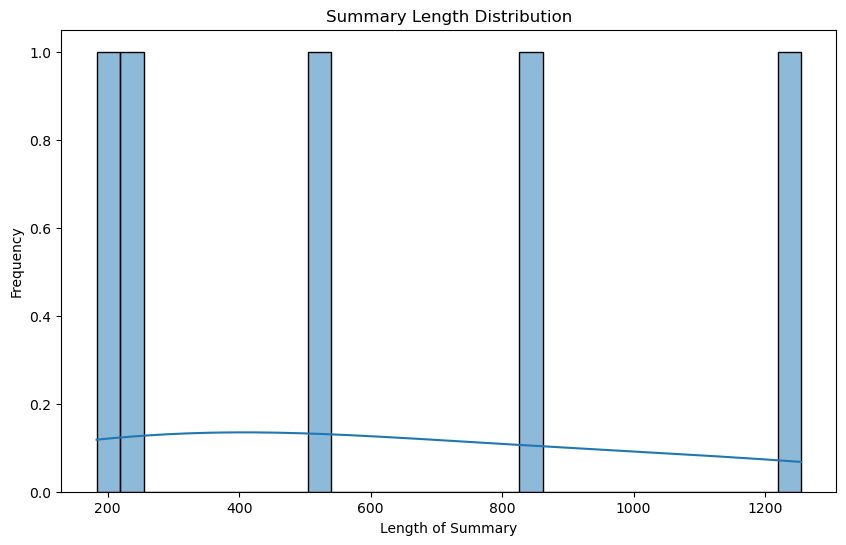

In [8]:
# Summary length distribution
df['summary_length'] = df['summary'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['summary_length'], bins=30, kde=True)
plt.title('Summary Length Distribution')
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')
plt.show()

## SpaCy For Knowledge Graph

**Imports and Installs**

In [9]:
pip install spacy


Note: you may need to restart the kernel to use updated packages.


In [10]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 787.7 kB/s eta 0:00:17
      --------------------------------------- 0.2/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.3/12.8 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.5/12.8 MB 2.3 MB/s eta 0:00:06
     -- ------------------------------------- 0.7/12.8 MB 2.6 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 2.7 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 2.8 MB/s eta 0:00:05
     --- ------------------------------------ 1.2/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.4/12.8 MB 2.9 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 3.1 MB/s eta 0:00:04
     ----- ---------------------------------- 1.7/12.8 MB 3.1 MB/

In [11]:
import spacy
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

### Loading Data and Tokonizing it

In [12]:
nlp = spacy.load('en_core_web_sm')
# Tokenize using spaCy
def spacy_tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

In [13]:
# Example
text = df['summary'].iloc[0]
spacy_tokens = spacy_tokenize(text)
print("spaCy Tokens:", spacy_tokens[:10])

spaCy Tokens: ['  ', 'Lecture', 'notes', 'optimization', 'machine', 'learning', 'derived', 'course', '\n', 'Princeton']


In [14]:
# Tokenize and extract entities using spaCy
def extract_entities_and_relationships(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    
    # Example relationship extraction (subject, object, relationship)
    relationships = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj") and token.head.pos_ == "VERB":
            relationships.append((token.head.text, token.text))
    
    return entities, relationships

### Building The Graph

In [15]:
# Build knowledge graph
def build_knowledge_graph(entities, relationships):
    graph = nx.DiGraph()
    
    # Add entities as nodes
    for entity, label in entities:
        graph.add_node(entity, label=label)
    
    # Add relationships as edges
    for subject, obj in relationships:
        graph.add_edge(subject, obj, relationship="related_to")
    
    return graph

In [16]:
# Visualize the knowledge graph
def visualize_knowledge_graph(graph):
    pos = nx.spring_layout(graph)
    labels = {node: node for node in graph.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_color="lightblue", node_size=3000, edge_color="gray", font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels={(u, v): d["relationship"] for u, v, d in graph.edges(data=True)})
    plt.show()

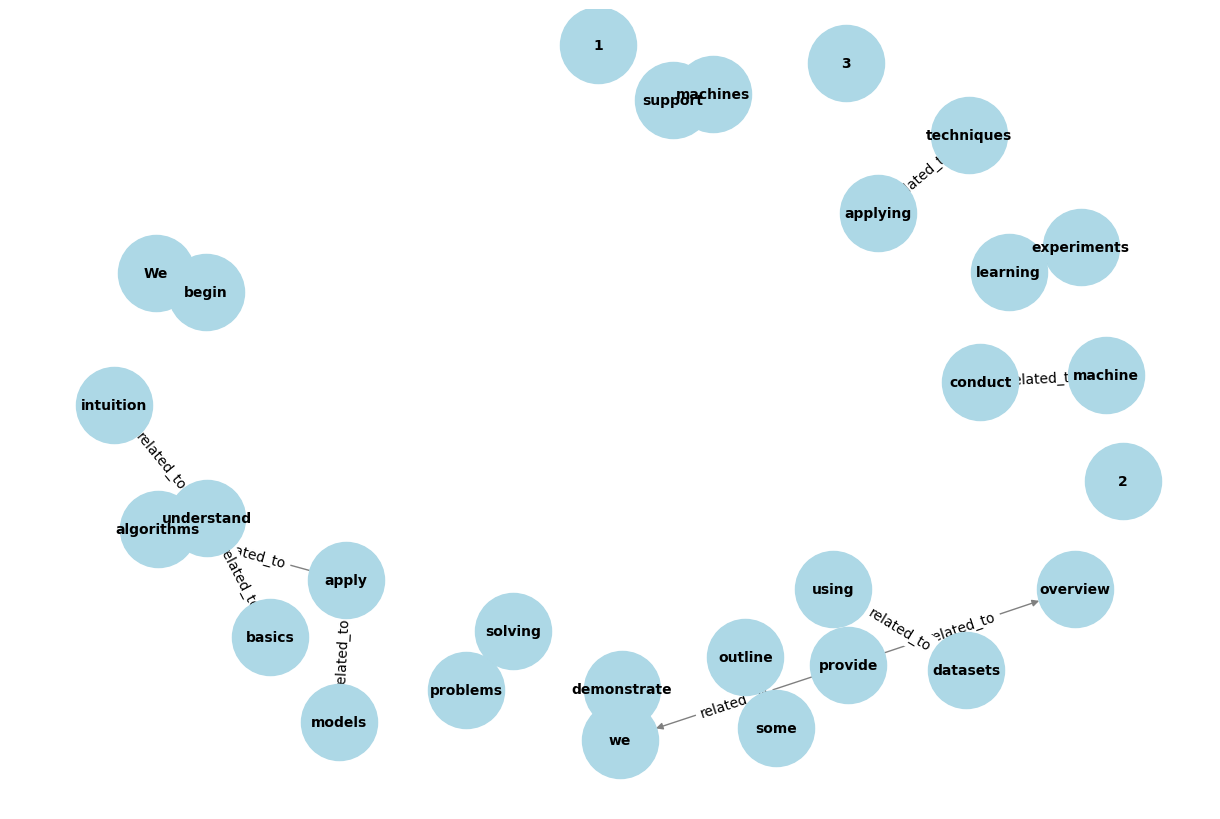

In [17]:
# Example
text = df['summary'].iloc[3]
entities, relationships = extract_entities_and_relationships(text)
knowledge_graph = build_knowledge_graph(entities, relationships)
visualize_knowledge_graph(knowledge_graph)

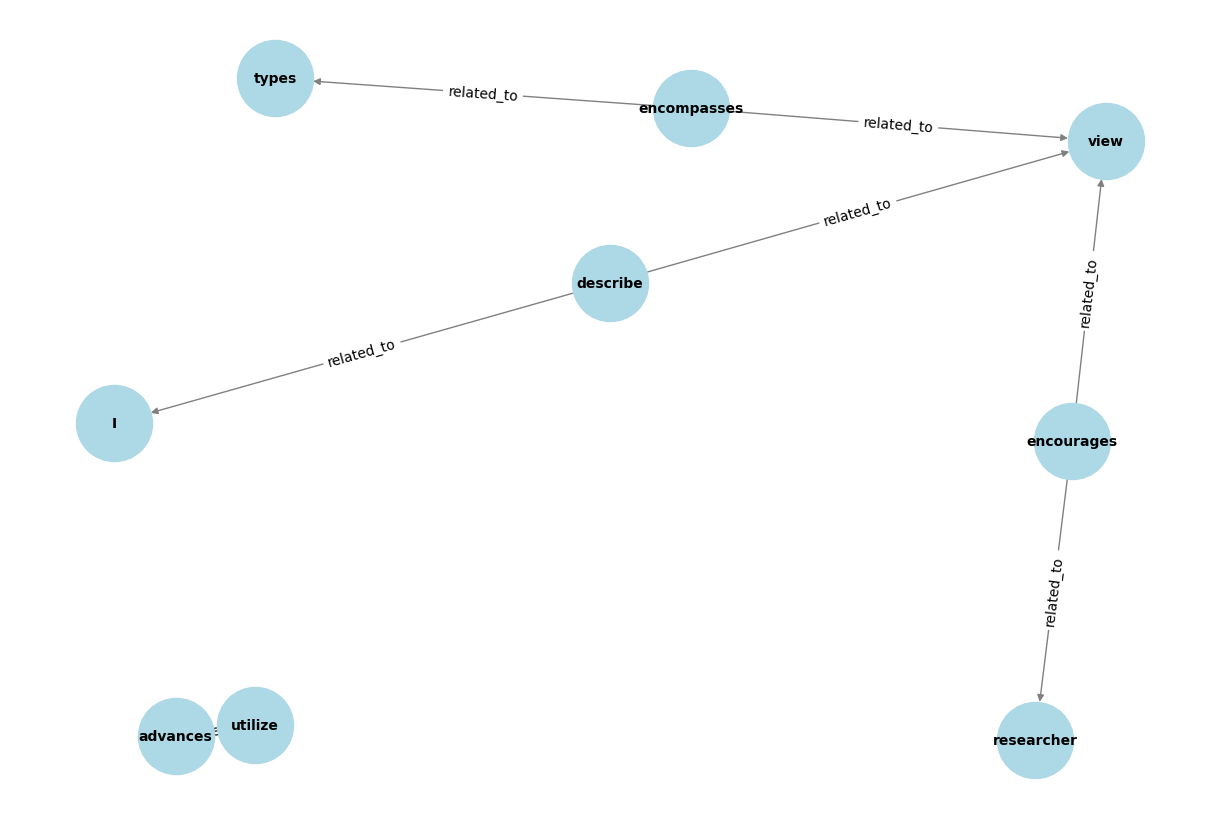

In [18]:
# Example
text = df['summary'].iloc[1]
entities, relationships = extract_entities_and_relationships(text)
knowledge_graph = build_knowledge_graph(entities, relationships)
visualize_knowledge_graph(knowledge_graph)

## NLTK

**Imports and Installs**

In [19]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [20]:
# Download NLTK resources if not available already
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Tokonizing Data

In [21]:
# Tokenize using NLTK
def nltk_tokenize(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return [word for word in words if word.isalpha() and word not in stop_words]

In [22]:
# Example
text = df['summary'].iloc[0]
nltk_tokens = nltk_tokenize(text)
print("NLTK Tokens:", nltk_tokens[:10])

NLTK Tokens: ['lecture', 'notes', 'optimization', 'machine', 'learning', 'derived', 'course', 'princeton', 'university', 'tutorials']


In [23]:
# Extract subject-verb-object relationships using POS tagging
def extract_relationships_nltk(text):
    tokens = nltk_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    # Simple subject-verb-object extraction based on POS tagging
    relationships = []
    for i in range(len(pos_tags) - 2):
        if pos_tags[i][1].startswith('NN') and pos_tags[i+1][1].startswith('VB') and pos_tags[i+2][1].startswith('NN'):
            subject = pos_tags[i][0]
            verb = pos_tags[i+1][0]
            obj = pos_tags[i+2][0]
            relationships.append((subject, verb, obj))
    
    return relationships

### Building Knowledge Graph

In [24]:
# Build knowledge graph
def build_knowledge_graph_nltk(relationships):
    graph = nx.DiGraph()
    
    # Add entities and relationships to the graph
    for subject, verb, obj in relationships:
        graph.add_node(subject)
        graph.add_node(obj)
        graph.add_edge(subject, obj, relationship=verb)
    
    return graph

In [25]:
# Visualize
def visualize_knowledge_graph(graph):
    pos = nx.spring_layout(graph)
    labels = {node: node for node in graph.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_color="lightgreen", node_size=3000, edge_color="gray", font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels={(u, v): d["relationship"] for u, v, d in graph.edges(data=True)})
    plt.show()

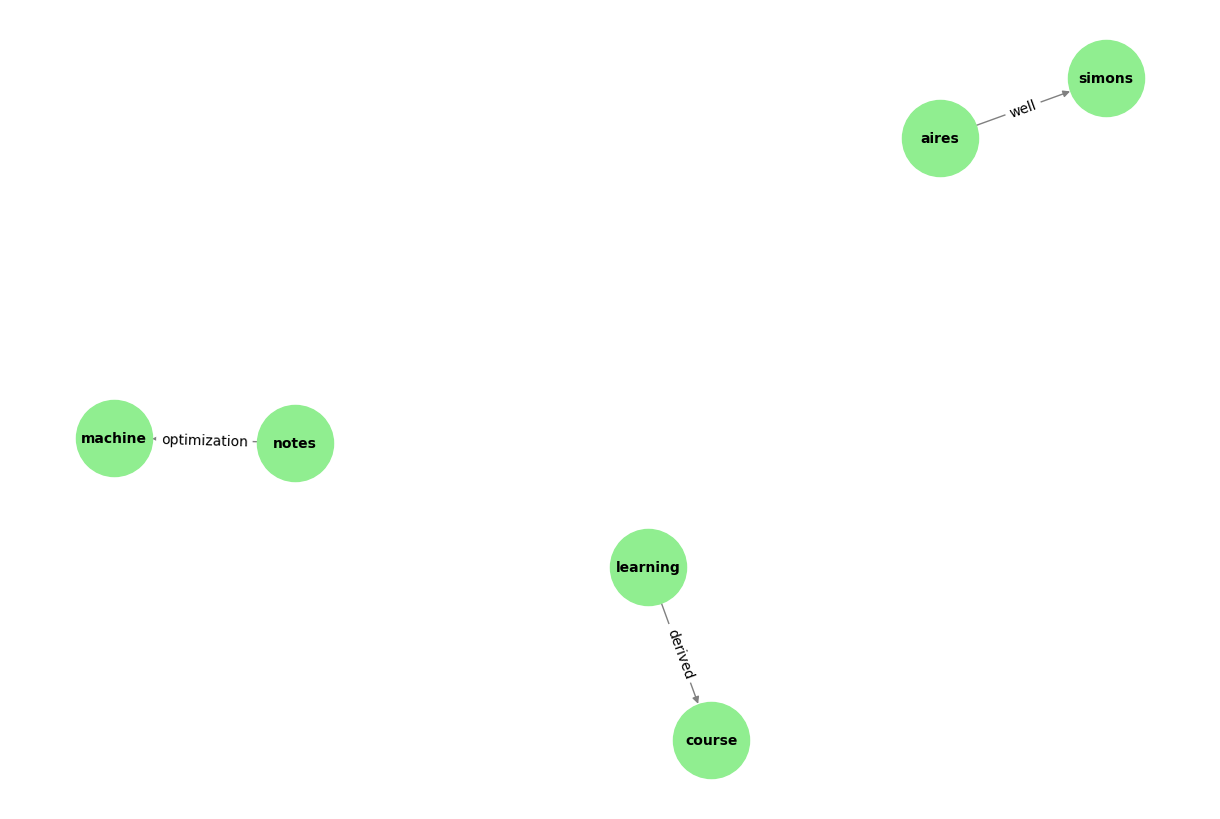

In [26]:
# Example
text = df['summary'].iloc[0]
relationships = extract_relationships_nltk(text)
knowledge_graph = build_knowledge_graph_nltk(relationships)
visualize_knowledge_graph(knowledge_graph)

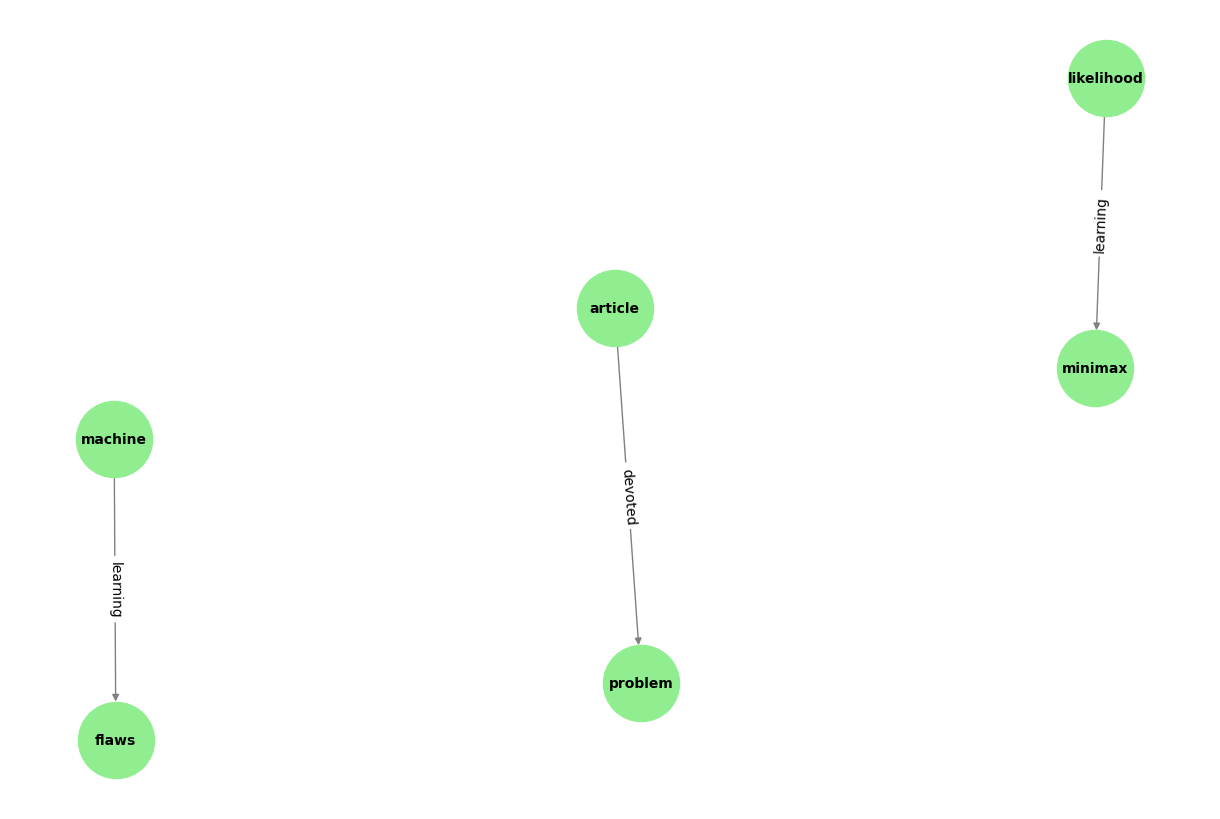

In [27]:
text = df['summary'].iloc[2]
relationships = extract_relationships_nltk(text)
knowledge_graph = build_knowledge_graph_nltk(relationships)
visualize_knowledge_graph(knowledge_graph)

## Models For Entity Mappping

In [28]:
from sklearn.model_selection import train_test_split

df = parse_arxiv_data(xml_data)

In [29]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [30]:
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.chunk import RegexpParser
from sklearn.metrics import precision_score, recall_score, f1_score
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

### SpaCy Model

In [31]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function for spaCy relationship extraction
def extract_relationships_spacy(text):
    doc = nlp(text)
    relationships = []

    for token in doc:
        if token.dep_ in ('nsubj', 'dobj'):
            subject = [w for w in token.head.lefts if w.dep_ == 'nsubj']
            if subject:
                relationships.append((subject[0].text, token.head.text, token.text))
    return relationships

### NLTK Model

In [32]:
# Function for NLTK relationship extraction
def extract_relationships_nltk(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    pos_tags = nltk.pos_tag(words)
    
    grammar = r"""
        NP: {<DT>?<JJ>*<NN>}
        VP: {<VB.*>}
    """
    chunk_parser = RegexpParser(grammar)
    tree = chunk_parser.parse(pos_tags)
    
    relationships = []
    subject, verb, obj = None, None, None

    for subtree in tree:
        if isinstance(subtree, nltk.Tree):
            if subtree.label() == 'NP':
                if subject is None:
                    subject = " ".join([token for token, pos in subtree.leaves()])
                else:
                    obj = " ".join([token for token, pos in subtree.leaves()])
            elif subtree.label() == 'VP':
                verb = " ".join([token for token, pos in subtree.leaves()])

            if subject and verb and obj:
                relationships.append((subject, verb, obj))
                subject, verb, obj = None, None, None

    return relationships

### Visualization, Relationships and Relation

In [33]:
# Visualization using NetworkX and Matplotlib
def visualize_relationships(relationships):
    G = nx.DiGraph()

    for rel in relationships:
        subject, verb, obj = rel
        G.add_edge(subject, obj, label=verb)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(35, 30))

    # Draw the nodes and edges
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, font_weight="bold", edge_color="gray")
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color="red")

    plt.title("Knowledge Graph of Extracted Relationships", fontsize=20)
    plt.show()

In [34]:
# Display relationships in a table format
def display_relationship_table(relationships):
    df = pd.DataFrame(relationships, columns=["Subject", "Verb", "Object"])
    print("\nRelationship Table:")
    print(df)

In [35]:
import pandas as pd
import networkx as nx

# Function to analyze relationships
def analyze_relationships(relationships):
    G = nx.DiGraph()
    for rel in relationships:
        subject, verb, obj = rel
        G.add_edge(subject, obj, label=verb)

    # Initialize analysis data
    nodes = list(G.nodes)
    analysis = {
        "Entity": nodes,
        "Self-Loops": [0] * len(nodes),
        "One-to-One": [None] * len(nodes),
        "One-to-Many": [None] * len(nodes),
        "Many-to-One": [None] * len(nodes)
    }

    # Calculate self-loops
    self_loops = [node for node in nodes if G.has_edge(node, node)]
    for node in nodes:
        if node in self_loops:
            analysis["Self-Loops"][nodes.index(node)] = len(list(G.successors(node)))

        successors = list(G.successors(node))
        predecessors = list(G.predecessors(node))
        if len(successors) > 1:
            analysis["One-to-Many"][nodes.index(node)] = node
        elif len(predecessors) > 1:
            analysis["Many-to-One"][nodes.index(node)] = node
        elif len(successors) == 1 and len(predecessors) == 1:
            analysis["One-to-One"][nodes.index(node)] = node

    # Convert None values to empty string
    for key in ["One-to-One", "One-to-Many", "Many-to-One"]:
        analysis[key] = [value if value is not None else "" for value in analysis[key]]

    # Create DataFrame
    df = pd.DataFrame(analysis)
    return df


#### Driver Program fot INPUT

In [36]:
# Main Program
algorithm_choice = input("Choose algorithm: Enter 1 for spaCy or 2 for NLTK: ")

if algorithm_choice == "1":
    extract_fn = extract_relationships_spacy
    print("You selected spaCy.")
elif algorithm_choice == "2":
    extract_fn = extract_relationships_nltk
    print("You selected NLTK.")
else:
    print("Invalid choice!")
    exit()

# Custom Input Interface
custom_input = input("Enter Text: ")
result = extract_fn(custom_input)

Choose algorithm: Enter 1 for spaCy or 2 for NLTK: 1
You selected spaCy.
Enter Text: The rapid advancement of technology has significantly transformed various aspects of human life, including communication, transportation, healthcare, and education. In the realm of communication, the advent of the internet and mobile devices has revolutionized the way people interact, making it possible to connect with others across the globe instantly. Social media platforms, email, and instant messaging services have become integral parts of daily life, enabling real-time communication and information sharing.  Transportation has also seen remarkable changes with the development of electric vehicles, autonomous driving technology, and high-speed trains. These innovations aim to reduce carbon emissions, enhance safety, and improve the efficiency of travel. Electric vehicles, for instance, are becoming increasingly popular as they offer a sustainable alternative to traditional gasoline-powered cars. Au

**This is the text sample used through out this project**

The rapid advancement of technology has significantly transformed various aspects of human life, including communication, transportation, healthcare, and education. In the realm of communication, the advent of the internet and mobile devices has revolutionized the way people interact, making it possible to connect with others across the globe instantly. Social media platforms, email, and instant messaging services have become integral parts of daily life, enabling real-time communication and information sharing.

Transportation has also seen remarkable changes with the development of electric vehicles, autonomous driving technology, and high-speed trains. These innovations aim to reduce carbon emissions, enhance safety, and improve the efficiency of travel. Electric vehicles, for instance, are becoming increasingly popular as they offer a sustainable alternative to traditional gasoline-powered cars. Autonomous driving technology promises to reduce human error, which is a leading cause of traffic accidents, thereby making roads safer.

In healthcare, technological advancements have led to the development of sophisticated medical equipment, telemedicine, and personalized medicine. Telemedicine allows patients to consult with healthcare providers remotely, making healthcare more accessible, especially in rural and underserved areas. Personalized medicine, which tailors treatment plans to individual genetic profiles, has the potential to improve the effectiveness of treatments and reduce adverse effects.

Education has also been transformed by technology, with the rise of online learning platforms, digital textbooks, and interactive learning tools. These resources provide students with flexible learning options and access to a wealth of information at their fingertips. Online learning platforms enable students to take courses from prestigious institutions worldwide, breaking down geographical barriers to education.

Despite these advancements, there are challenges associated with the rapid pace of technological change. Issues such as data privacy, cybersecurity, and the digital divide need to be addressed to ensure that the benefits of technology are equitably distributed. Data privacy concerns arise from the vast amounts of personal information collected by various online services, which can be vulnerable to breaches and misuse. Cybersecurity threats, including hacking and malware attacks, pose significant risks to individuals and organizations alike. The digital divide, which refers to the gap between those who have access to modern technology and those who do not, can exacerbate social and economic inequalities.

#### OUTPUT

In [37]:
# Display Results
print("\nExtracted Relationships:", result)


Extracted Relationships: [('advancement', 'transformed', 'advancement'), ('advancement', 'transformed', 'aspects'), ('advent', 'revolutionized', 'advent'), ('advent', 'revolutionized', 'way'), ('people', 'interact', 'people'), ('it', 'possible', 'it'), ('platforms', 'become', 'platforms'), ('Transportation', 'seen', 'Transportation'), ('Transportation', 'seen', 'changes'), ('innovations', 'aim', 'innovations'), ('vehicles', 'becoming', 'vehicles'), ('they', 'offer', 'they'), ('they', 'offer', 'alternative'), ('technology', 'promises', 'technology'), ('which', 'is', 'which'), ('roads', 'safer', 'roads'), ('advancements', 'led', 'advancements'), ('Telemedicine', 'allows', 'Telemedicine'), ('patients', 'consult', 'patients'), ('healthcare', 'accessible', 'healthcare'), ('medicine', 'has', 'medicine'), ('which', 'tailors', 'which'), ('which', 'tailors', 'plans'), ('medicine', 'has', 'potential'), ('resources', 'provide', 'resources'), ('resources', 'provide', 'students'), ('platforms', 'e

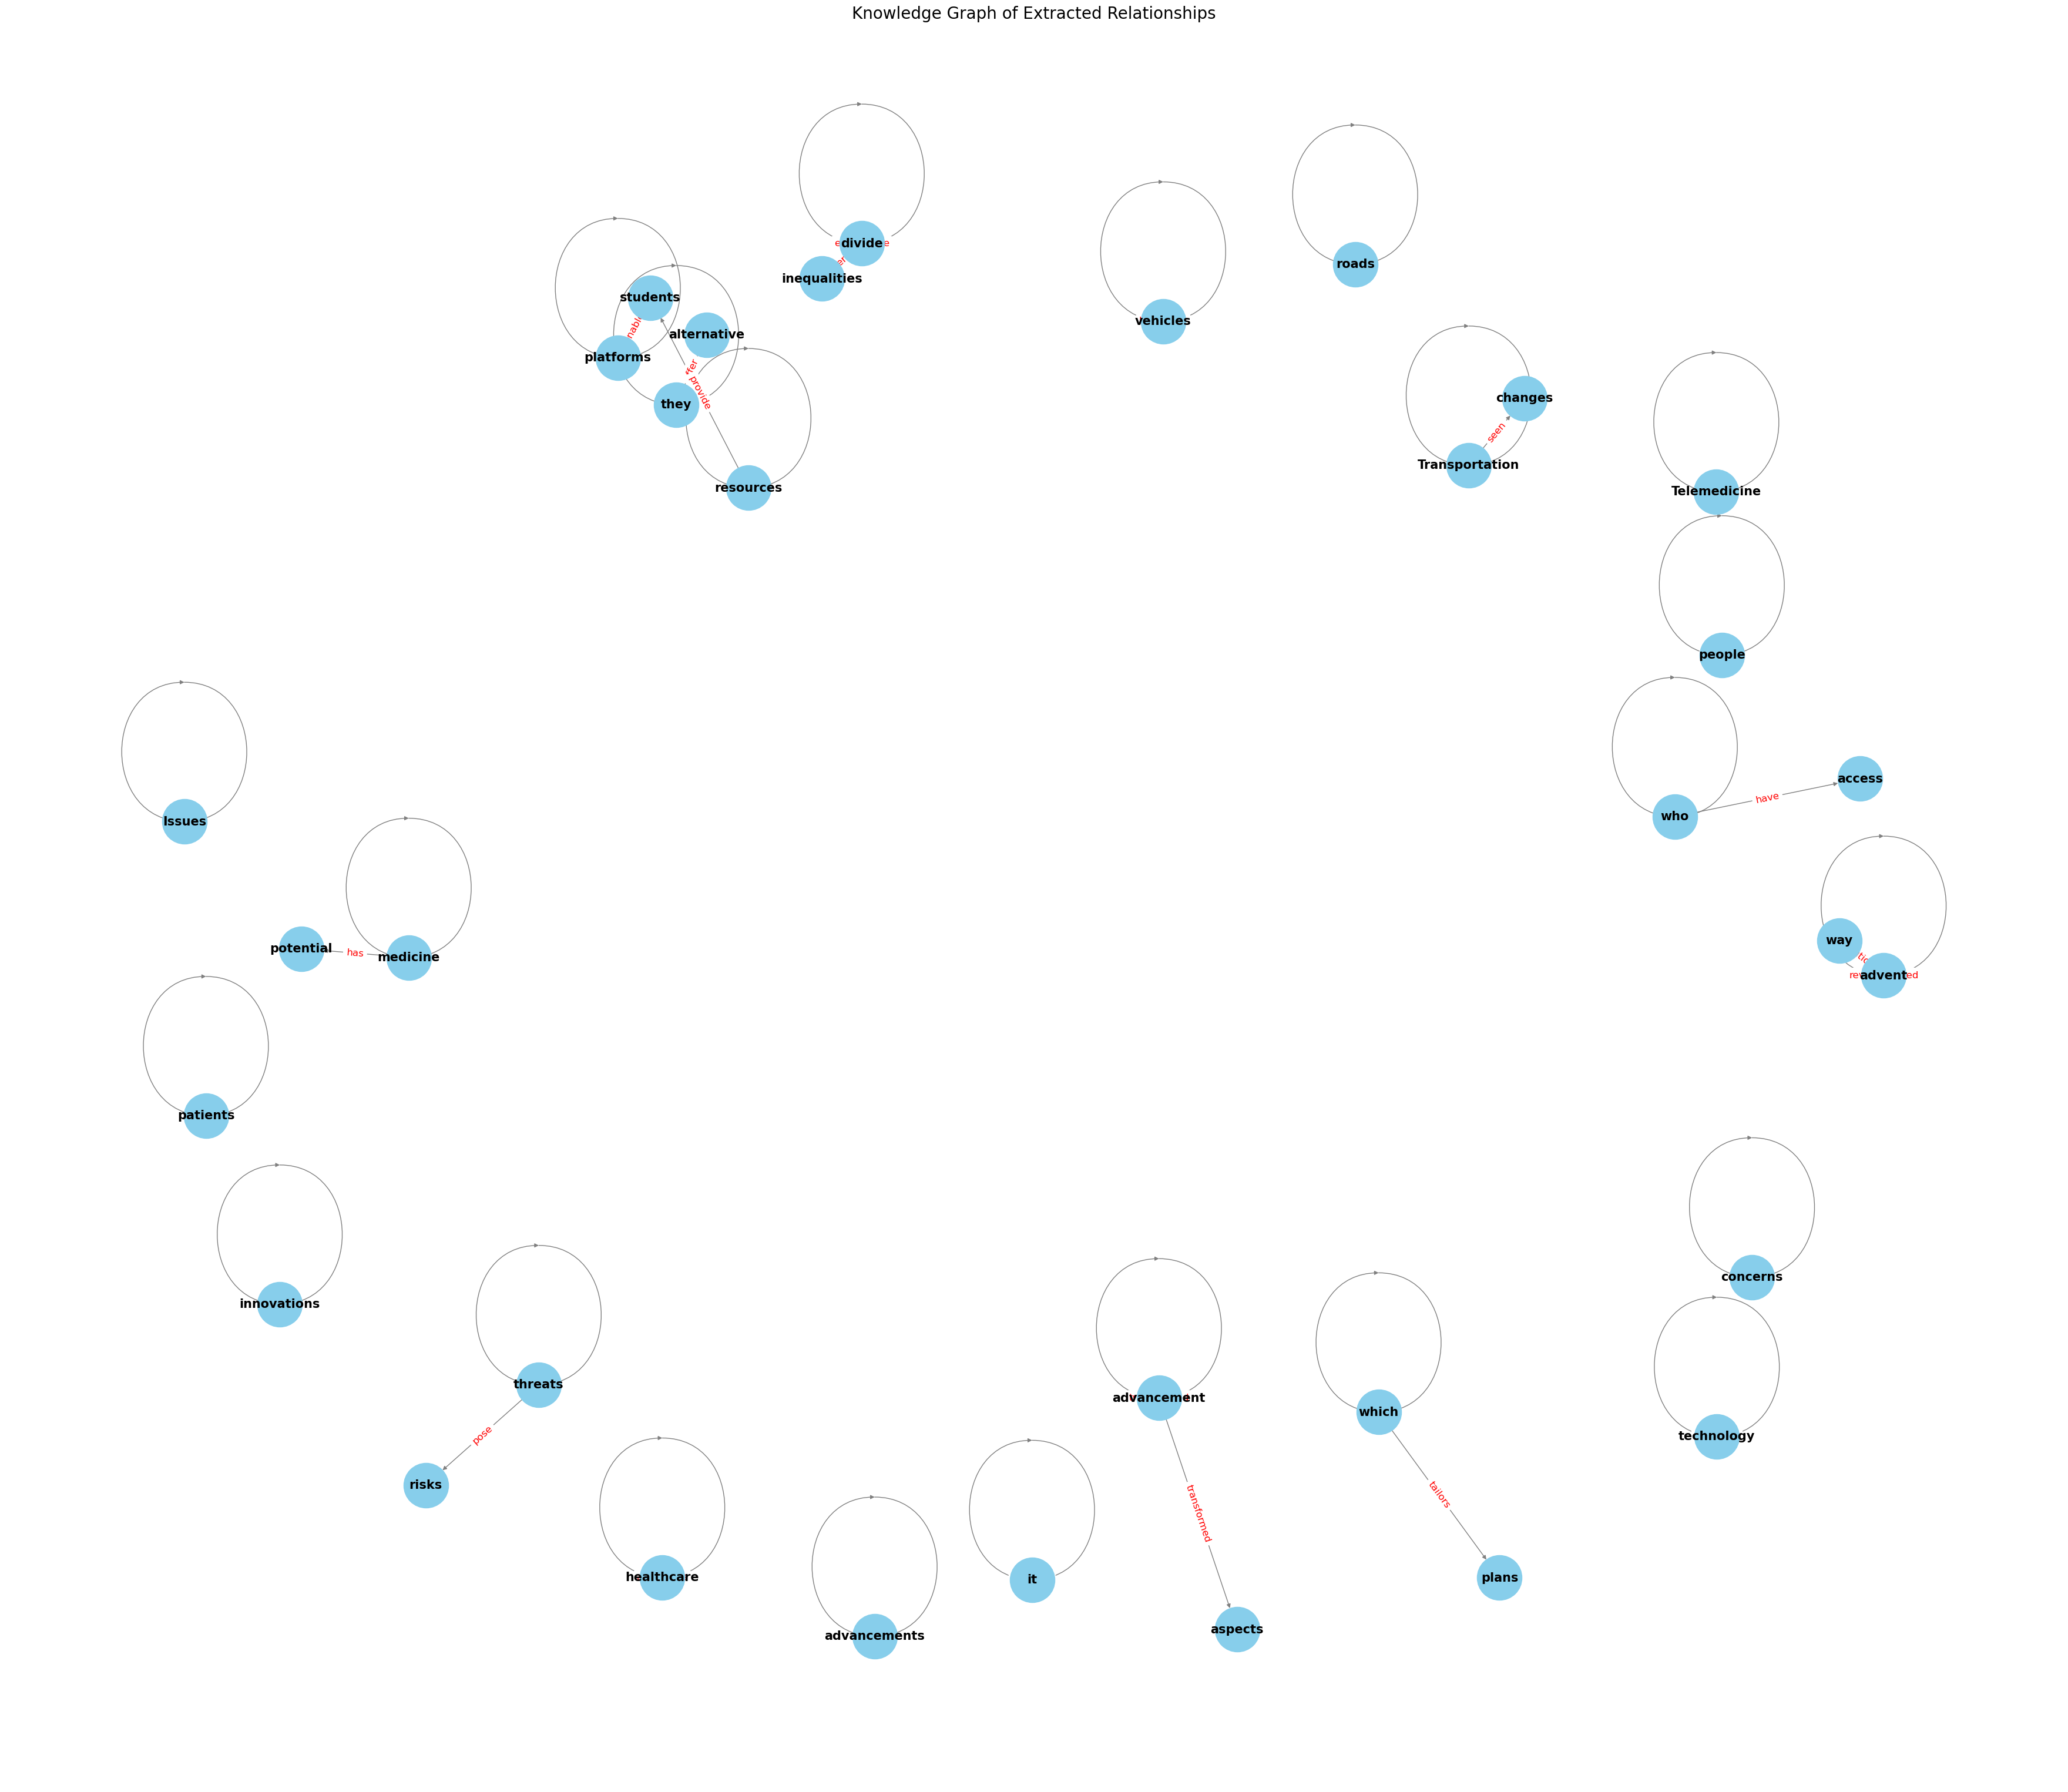

In [38]:
# Visualize the relationships as a knowledge graph
visualize_relationships(result)

In [39]:
# Analyze Relationships
df_analysis = analyze_relationships(result)
print("\nExtracted Relationships:", result)
print("\nKnowledge Graph Relationship Analysis:")
print(df_analysis)


Extracted Relationships: [('advancement', 'transformed', 'advancement'), ('advancement', 'transformed', 'aspects'), ('advent', 'revolutionized', 'advent'), ('advent', 'revolutionized', 'way'), ('people', 'interact', 'people'), ('it', 'possible', 'it'), ('platforms', 'become', 'platforms'), ('Transportation', 'seen', 'Transportation'), ('Transportation', 'seen', 'changes'), ('innovations', 'aim', 'innovations'), ('vehicles', 'becoming', 'vehicles'), ('they', 'offer', 'they'), ('they', 'offer', 'alternative'), ('technology', 'promises', 'technology'), ('which', 'is', 'which'), ('roads', 'safer', 'roads'), ('advancements', 'led', 'advancements'), ('Telemedicine', 'allows', 'Telemedicine'), ('patients', 'consult', 'patients'), ('healthcare', 'accessible', 'healthcare'), ('medicine', 'has', 'medicine'), ('which', 'tailors', 'which'), ('which', 'tailors', 'plans'), ('medicine', 'has', 'potential'), ('resources', 'provide', 'resources'), ('resources', 'provide', 'students'), ('platforms', 'e

In [40]:
# Display relationships in a table
display_relationship_table(result)


Relationship Table:
           Subject            Verb          Object
0      advancement     transformed     advancement
1      advancement     transformed         aspects
2           advent  revolutionized          advent
3           advent  revolutionized             way
4           people        interact          people
5               it        possible              it
6        platforms          become       platforms
7   Transportation            seen  Transportation
8   Transportation            seen         changes
9      innovations             aim     innovations
10        vehicles        becoming        vehicles
11            they           offer            they
12            they           offer     alternative
13      technology        promises      technology
14           which              is           which
15           roads           safer           roads
16    advancements             led    advancements
17    Telemedicine          allows    Telemedicine
18        

## Summarizing Using GPT

**Imports and Installs**

In [41]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras


In [42]:
import keras_nlp
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


### Parameters

In [43]:
max_vocab_size = 10000  # Maximum size of the vocabulary
max_sequence_length = 500  # Maximum length of the sequences
embedding_dim = 128  # Dimension of embedding vectors
hidden_units = 512  # Number of hidden units in transformer layers
num_layers = 4  # Number of transformer layers
num_heads = 8  # Number of attention heads


In [44]:
print(parse_arxiv_data(xml_data).columns)


Index(['title', 'summary', 'authors', 'url'], dtype='object')


In [45]:
df = parse_arxiv_data(xml_data)

In [46]:
titles = df['title'].tolist()
summaries = df['summary'].tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(titles, summaries, test_size=0.2, random_state=42)

### Tokenization

#### Loading Tokenizer

In [47]:
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train + y_train)  # Fit tokenizer on both input and output texts

# Adding special tokens
special_tokens = ["<PAD>", "<START>", "<END>", "<UNK>"]
for token in special_tokens:
    tokenizer.word_index[token] = len(tokenizer.word_index) + 1
    tokenizer.index_word[len(tokenizer.word_index)] = token

#### Tokenizing Data

In [48]:
# Tokenize data
def tokenize(texts, max_len=max_sequence_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences

X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)
y_train_tokens = tokenize(y_train)
y_test_tokens = tokenize(y_test)

### Model Implementation

#### Checking before implementing

In [49]:
import keras_nlp
print(dir(keras_nlp.layers))


['MaskedLM', 'OnDeviceEmbedding', 'PositionEmbedding', 'SelfAttentionMask', 'TransformerEncoderBlock', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'masked_lm', 'on_device_embedding', 'position_embedding', 'self_attention_mask', 'transformer_encoder_block']


In [50]:
import tensorflow as tf
print(tf.__version__)


2.18.0-dev20240815


### Model Building

#### Imports

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.models import Model

# Define model hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
hidden_units = 512
num_layers = 4
num_heads = 8
max_sequence_length = 500  # Make sure this matches your data

# Define the model inputs
input_text = Input(shape=(max_sequence_length,), name='input_text')
target_text = Input(shape=(max_sequence_length,), name='target_text')

#### Embedding and Encoding

In [52]:
# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)

# Encoder
def build_encoder(inputs):
    x = embedding_layer(inputs)
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim
        )(x, x)
        x = Add()([x, attn_output])  # Skip connection
        x = LayerNormalization()(x)
        
        # Feed-forward network
        ff_output = Dense(hidden_units, activation='relu')(x)
        ff_output = Dense(embedding_dim)(ff_output)
        x = Add()([x, ff_output])  # Skip connection
        x = LayerNormalization()(x)
    return x

#### Decoding

In [53]:
# Decoder
def build_decoder(inputs, encoder_output):
    x = embedding_layer(inputs)
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim
        )(x, x)
        x = Add()([x, attn_output])  # Skip connection
        x = LayerNormalization()(x)
        
        # Cross-attention with encoder output
        cross_attn_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim
        )(x, encoder_output)
        x = Add()([x, cross_attn_output])  # Skip connection
        x = LayerNormalization()(x)
        
        # Feed-forward network
        ff_output = Dense(hidden_units, activation='relu')(x)
        ff_output = Dense(embedding_dim)(ff_output)
        x = Add()([x, ff_output])  # Skip connection
        x = LayerNormalization()(x)
    return x

In [54]:
# Build the encoder and decoder
encoder_output = build_encoder(input_text)
decoder_output = build_decoder(target_text, encoder_output)

# Output layer
output = Dense(vocab_size, activation='softmax')(decoder_output)

# Create and compile the model
model = Model(inputs=[input_text, target_text], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Model Summary

In [55]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_text         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_text          │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 128)  │     25,344 │ input_text[0][0], │
│ (Embedding)         │                   │            │ target_text[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 500)       │          0 │ input_text[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 128)  │    527,488 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 128)  │          0 │ embedding[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 500, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 500, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 500, 128)  │     65,664 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 500, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or          │ (None, 500)       │          0 │ not_equal[0][0],  │
│ (LogicalOr)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_1        │ (None, 500)       │          0 │ logical_or[0][0], │
│ (LogicalOr)         │                   │            │ logical_or[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ logical_or_1[0][… │
│                     │                   │            │ logical_or_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 500, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 7,439,558 (28.38 MB)

 Trainable params: 7,439,558 (28.38 MB)

 Non-trainable params: 0 (0.00 B)

### Random search, Top-K search, Top-P search and Greedy search

**Imports and Installs**

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [57]:
def preprocess_input(text, max_length):
    # Tokenize the text and convert to sequence
    sequence = tokenizer.texts_to_sequences([text])[0]
    
    # Pad the sequence to ensure it has the max_length
    padded_sequence = pad_sequences([sequence], maxlen=max_length, padding='post')[0]
    return padded_sequence


#### Demonstration Usage

#### Batch Processing:
**Using smaller data and smaller sequence lengths (for both i/p and o/p)**

In [64]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the tokenize function
def tokenize_the_text(texts, max_len=100):  # Set max_len to match your model's expected input length
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences

# Define the summary generation function
def generate_summary(model, tokenizer, input_text, max_sequence_length=50, sampling_method='greedy', **kwargs):  # Set max_sequence_length to match your model's expected input length
    input_seq = tokenize_the_text([input_text], max_len=max_sequence_length)
    target_seq = np.zeros((1, max_sequence_length))  # Start with empty target sequence

    for i in range(max_sequence_length):
        predictions = model.predict([input_seq, target_seq], verbose=0)
        if sampling_method == 'greedy':
            next_token = np.argmax(predictions[0, i, :])
        elif sampling_method == 'random':
            next_token_probs = predictions[0, i, :]
            next_token = np.random.choice(len(next_token_probs), p=next_token_probs)
        elif sampling_method == 'top_k':
            k = kwargs.get('k', 10)
            next_token_probs = predictions[0, i, :]
            top_k_indices = np.argsort(next_token_probs)[-k:]
            top_k_probs = next_token_probs[top_k_indices]
            top_k_probs /= top_k_probs.sum()
            next_token = np.random.choice(top_k_indices, p=top_k_probs)
        elif sampling_method == 'top_p':
            p = kwargs.get('p', 0.8)
            next_token_probs = predictions[0, i, :]
            sorted_indices = np.argsort(next_token_probs)
            sorted_probs = next_token_probs[sorted_indices]
            cumulative_probs = np.cumsum(sorted_probs)
            cutoff_index = np.where(cumulative_probs > p)[0][0]
            top_p_indices = sorted_indices[:cutoff_index + 1]
            top_p_probs = next_token_probs[top_p_indices]
            top_p_probs /= top_p_probs.sum()
            next_token = np.random.choice(top_p_indices, p=top_p_probs)

        if next_token == tokenizer.word_index.get("<END>", 0):
            break
        target_seq[0, i] = next_token

    summary = tokenizer.sequences_to_texts([target_seq[0]])[0]
    return summary

# Function to take user input and generate summaries
def get_input_text():
    input_text = input("Enter the text you want to summarize: ")
    return input_text

# Main function to generate summaries using different sampling methods
def main():
    input_text = get_input_text()
    
        
    print("\n\nGenerating summary using Greedy Search...")
    greedy_summary = generate_summary(model, tokenizer, input_text, sampling_method='greedy')
    print("Summary (Greedy Search):")
    print(greedy_summary)
    print("-" * 50)

    print("\n\nGenerating summary using Random Sampling...")
    random_summary = generate_summary(model, tokenizer, input_text, sampling_method='random')
    print("Summary (Random Sampling):")
    print(random_summary)
    print("-" * 50)

    print("\n\nGenerating summary using Top-K Sampling...")
    top_k_summary = generate_summary(model, tokenizer, input_text, sampling_method='top_k', k=10)
    print("Summary (Top-K Sampling):")
    print(top_k_summary)
    print("-" * 50)

    print("\n\nGenerating summary using Top-P Sampling...")
    top_p_summary = generate_summary(model, tokenizer, input_text, sampling_method='top_p', p=0.8)
    print("Summary (Top-P Sampling):")
    print(top_p_summary)
    print("-" * 50)

if __name__ == "__main__":
    main()


Enter the text you want to summarize: The rapid advancement of technology has significantly transformed various aspects of human life, including communication, transportation, healthcare, and education. In the realm of communication, the advent of the internet and mobile devices has revolutionized the way people interact, making it possible to connect with others across the globe instantly. Social media platforms, email, and instant messaging services have become integral parts of daily life, enabling real-time communication and information sharing.  Transportation has also seen remarkable changes with the development of electric vehicles, autonomous driving technology, and high-speed trains. These innovations aim to reduce carbon emissions, enhance safety, and improve the efficiency of travel. Electric vehicles, for instance, are becoming increasingly popular as they offer a sustainable alternative to traditional gasoline-powered cars. Autonomous driving technology promises to reduce 

**NOTE:** The above set of code will give highly suboptimal output, it is here for demonstration purpose since it takes less time to generate summary.

#### Actual Application

**Random search**

In [65]:
def random_sampling(model, tokenizer, input_text, max_sequence_length=500):
    input_seq = tokenize([input_text], max_len=max_sequence_length)
    target_seq = np.zeros((1, max_sequence_length))  # Start with empty target sequence

    for i in range(max_sequence_length):
        predictions = model.predict([input_seq, target_seq], verbose=0)
        next_token_probs = predictions[0, i-1, :]
        next_token = np.random.choice(len(next_token_probs), p=next_token_probs)
        if next_token == tokenizer.word_index["<END>"]:
            break
        target_seq[0, i] = next_token

    summary = tokenizer.sequences_to_texts(target_seq)[0]
    return summary


**Top-K search**

In [66]:
def top_k_sampling(model, tokenizer, input_text, k=50, max_sequence_length=500):
    input_seq = tokenize([input_text], max_len=max_sequence_length)
    target_seq = np.zeros((1, max_sequence_length))  # Start with empty target sequence

    for i in range(max_sequence_length):
        predictions = model.predict([input_seq, target_seq], verbose=0)
        next_token_probs = predictions[0, i-1, :]
        top_k_indices = np.argsort(next_token_probs)[-k:]
        top_k_probs = next_token_probs[top_k_indices]
        top_k_probs /= top_k_probs.sum()
        next_token = np.random.choice(top_k_indices, p=top_k_probs)
        if next_token == tokenizer.word_index["<END>"]:
            break
        target_seq[0, i] = next_token

    summary = tokenizer.sequences_to_texts(target_seq)[0]
    return summary


**Top-P search**

In [67]:
def top_p_sampling(model, tokenizer, input_text, p=0.9, max_sequence_length=500):
    input_seq = tokenize([input_text], max_len=max_sequence_length)
    target_seq = np.zeros((1, max_sequence_length))  # Start with empty target sequence

    for i in range(max_sequence_length):
        predictions = model.predict([input_seq, target_seq], verbose=0)
        next_token_probs = predictions[0, i-1, :]
        sorted_indices = np.argsort(next_token_probs)
        sorted_probs = next_token_probs[sorted_indices]
        cumulative_probs = np.cumsum(sorted_probs)
        cutoff_index = np.where(cumulative_probs > p)[0][0]
        top_p_indices = sorted_indices[:cutoff_index + 1]
        top_p_probs = next_token_probs[top_p_indices]
        top_p_probs /= top_p_probs.sum()
        next_token = np.random.choice(top_p_indices, p=top_p_probs)
        if next_token == tokenizer.word_index["<END>"]:
            break
        target_seq[0, i] = next_token

    summary = tokenizer.sequences_to_texts(target_seq)[0]
    return summary


**Greedy Search**

In [68]:
def greedy_search(model, tokenizer, input_text, max_sequence_length=500):
    input_seq = tokenize([input_text], max_len=max_sequence_length)
    target_seq = np.zeros((1, max_sequence_length))  # Start with empty target sequence

    for i in range(max_sequence_length):
        predictions = model.predict([input_seq, target_seq], verbose=0)
        next_token = np.argmax(predictions[0, i-1, :])
        if next_token == tokenizer.word_index["<END>"]:
            break
        target_seq[0, i] = next_token

    summary = tokenizer.sequences_to_texts(target_seq)[0]
    return summary


**Actual Summarization model Driver Funcrion**

In [ ]:
def main():
    input_text = input("Enter the text you want to summarize: ")

    print("\n\n Generating summary using Random Sampling...")
    random_summary = random_sampling(model, tokenizer, input_text)
    print("Summary (Random Sampling):")
    print(random_summary)
    print("-" * 50)

    print("\n\n Generating summary using Top-K Sampling...")
    top_k_summary = top_k_sampling(model, tokenizer, input_text)
    print("Summary (Top-K Sampling):")
    print(top_k_summary)
    print("-" * 50)

    print("\n\n Generating summary using Top-P Sampling...")
    top_p_summary = top_p_sampling(model, tokenizer, input_text)
    print("Summary (Top-P Sampling):")
    print(top_p_summary)
    print("-" * 50)
    
    print("\n\n Generating summary using Greedy Search...")
    greedy_summary = greedy_search(model, tokenizer, input_text)
    print("Summary (Greedy Search):")
    print(greedy_summary)
    print("-" * 50)


if __name__ == "__main__":
    main()


**NOTE:** This gives optimal output, but takes a long time to generate.